In [1]:
# for plotting
%matplotlib inline

In [2]:
# imports
# import pandas as pd
import seaborn as sns
# import statsmodels.api as sm

sns.set_theme()

from exp_utils import *
# from patsy import dmatrices

In [3]:
# load data
df = collate_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   zrc.subset                                 1656 non-null   category
 1   zrc.speaker_mode                           1656 non-null   category
 2   zrc.context_mode                           1656 non-null   category
 3   zrc.granularity                            1656 non-null   category
 4   zrc.score                                  1656 non-null   float64 
 5   zrc.pooling                                1656 non-null   category
 6   zrc.seed                                   1656 non-null   category
 7   zrc.pca_style                              1656 non-null   category
 8   feat_type                                  1656 non-null   category
 9   input_size                                 1656 non-null   int64   
 10  latent_type 

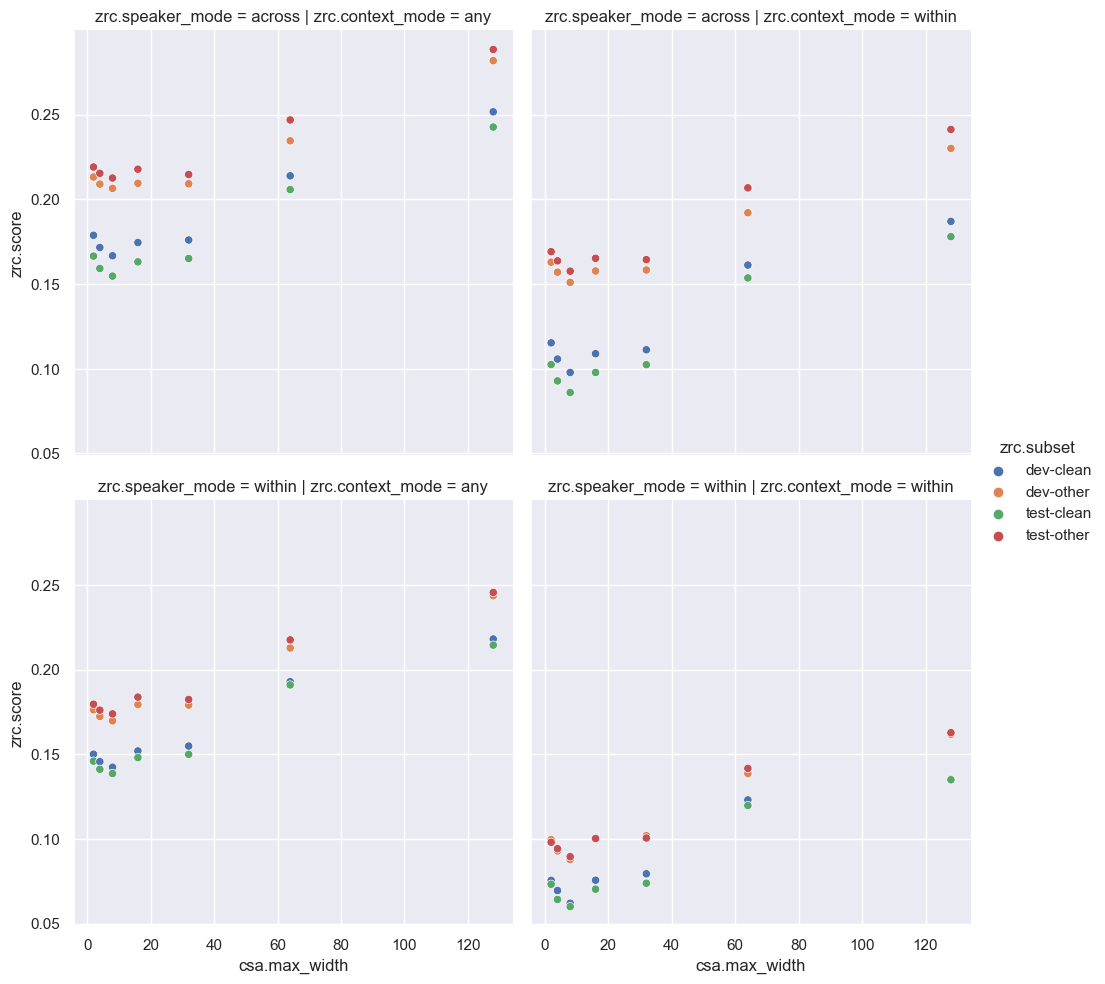

In [5]:
# plot
df_ = filter_data_equal(df, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "zrc.granularity": "phoneme"
})
df_ = filter_data_in(df_, {"csa.max_width": (float(x) for x in range(1, 129))})
check_data(df_, "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode", "zrc.context_mode", "training.cpc_loss.offset")
plt = sns.relplot(df_, x="csa.max_width", y="zrc.score", row="zrc.speaker_mode", col="zrc.context_mode", hue="zrc.subset")
plt.set(xscale='log')